# FDS challenge: Siri/Barberio/Impera
- Hello everyone!! this is our final notebook for the FDS: Pokèmon Battles prediction 2025.
- **Group name**: Siri/Barberio/Impera.
- Before displaying the submission sets, you will find three markdown sections, one for each submission, explaining the corresponding approach.
- *notes: The 4th member of the group, "Roksana Akter", has been replaced with"Barberio".*

In [1]:
# =========================
#     GLOBAL IMPORTS
# =========================

import os
import json
import numpy as np
import pandas as pd

from IPython.display import display
from tqdm import tqdm

from collections import Counter, defaultdict
from typing import List, Dict, Any, Tuple

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# XGBoost
import xgboost as xgb

In [2]:
# --- 1. REPO GITHUB ---

GITHUB_USERNAME = "Vitaliano23"
REPO_NAME = "FDS_COMP_2025"

GIT_URL = f"https://github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"
print(f"Cloning public repository: {GIT_URL}")

!git clone {GIT_URL}

print("\n✅ Repository cloned successfully.\n")



Cloning public repository: https://github.com/Vitaliano23/FDS_COMP_2025.git
Cloning into 'FDS_COMP_2025'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 125 (delta 60), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 344.05 KiB | 7.02 MiB/s, done.
Resolving deltas: 100% (60/60), done.

✅ Repository cloned successfully.



In [3]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)
train_file_path = "/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl"
test_file_path = "/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl"

train_data = []
test_data  = []

# --- Load TRAIN data ---
print(f"📦 Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))
    print(f"✅ Successfully loaded {len(train_data)} battles from train.")
    
    # Show structure of first train battle
    if train_data:
        print("\n--- Structure of the first train battle: ---")
        first_battle = train_data[0]
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = first_battle.get('battle_timeline', [])[:2]
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")


# --- Load TEST data ---
print(f"\n📦 Loading data from '{test_file_path}'...")
try:
    with open(test_file_path, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
    print(f"✅ Successfully loaded {len(test_data)} battles from test.")
    
    if test_data:
        print("\n--- Structure of the first test battle: ---")
        first_test_battle = test_data[0]
        test_display = first_test_battle.copy()
        test_display['battle_timeline'] = test_display.get('battle_timeline', [])[:2]
        print(json.dumps(test_display, indent=4))
        if len(first_test_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find the test file at '{test_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")



📦 Loading data from '/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl'...
✅ Successfully loaded 10000 battles from train.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
     

# SUBMISSION 1 - for *"fork-of-vit-notebook-fds2-final.py"*
- **Feature engineering**:
    - Comprehensive, deterministic pipeline that combines static team information, per‑pokemon base stats, timeline-derived signals, move details, matchup heuristics and global aggregated statistics.
    - Static team stats: team size, unique type counts, sums and averages of base stats (base_hp, base_atk, base_def, base_spa, base_spd, base_spe), team stat variance, and team speed summaries (mean, max). Also counts of how many team members out‑speed the opponent’s lead.
    - Timeline-derived HP features: for each battle the code extracts p1/p2 hp_pct series (up to 30 turns) and computes mean, last, std, min, slope, AUC, fraction of turns in advantage, KO counts, early-window summaries (first 3/5/10), and first‑KO flags.
Move-level statistics: per-side (p1/p2) move base_power, accuracy and priority means and maxima for full and early windows (5/10). Also counts per category (PHYSICAL/SPECIAL/STATUS).
    - Type effectiveness & STAB: per-move type multipliers using a TYPE_CHART; averages of effectiveness for P1 moves vs P2 lead (full/5/10), STAB ratios/power means for P1 and lead-only approximations for P2.
    - Matchup/damage proxies: a simple damage-index combining base_power, STAB, type multiplier and attack/defense proxies; a lead matchup index computed over full/5/10 windows.
    - Momentum, hazards and tactical signals: switch counts, hazard presence flags, recovery counts, momentum shift (3 vs 10 turns), damage_trade_ratio (weighted), forced/voluntary leave heuristics, late/early game differences and “final battle score” heuristics with a sigmoid-derived final_win_probability.
    - Global training-time stats (computed once from the whole train set and merged back): per-Pokémon winrates (Laplace-smoothed), per-Pokémon average final HP, per-Pokémon average damage. Those are aggregated to team-level features (team_winrate_score, team_avg_hp_score, avg_damage features).
    - Interaction & composite features: manual multiplications (team strength × move power, speed × priority, etc.), “extra” composite features such as damage × status, signed-log transforms for skewed features, and many bounded, safe fallbacks to avoid NaN/Inf.
    - Clustering-based meta feature: KMeans clustering over the scaled feature matrix (automatic best-K selection using silhouette), then cluster → cluster_win_rate mapping is computed and appended as cluster_id and cluster_win_rate features for train and test.
Sanitization & scaling: fillna/clip/replace inf steps; final RobustScaler fitted on train numeric columns and applied to both train and test. Dataframes train_df_raw / test_df_raw are kept as raw copies for inspection.
- **Feature selection**:

    - Correlation and constant pruning: a utility drops constant columns and then removes one feature from pairs with |corr| > 0.92 (this reduces redundancy before later selection).
    - L1-based selection: the notebook fits an L1 LogisticRegression on a train/val split (balanced class option used in one experiment), takes absolute coefficients and keeps features with coefficient magnitude above a small threshold (example: 0.003). This produces a selected feature set used for a stronger retrained L1 model.
    - Practical pipeline: the notebook shows both a correlation-pruned set (used for several experiments) and an L1-selected smaller subset (used for final compact Logistic models). It preserves the contract expected by downstream cells (variables like model, features, train_selected, test_selected).
- **Modeling & stacking**:
    - Base models explored and tuned inside the notebook:
        - Logistic Regression (baseline): standard solver, used as an initial baseline and retrained on various subsets.
        - L1 Logistic Regression: used for sparsity-aware feature selection and as a competitive base learner.
        - K-Nearest Neighbors: K selected by CV across candidate k values (example list: 3,5,7,...,31), then fitted and used as a base learner.
        - Random Forest: two profiles compared via CV ("shallow" vs "deep") and best chosen; used as a base learner and for feature importances in experiments.
        - XGBoost: hist tree method with sensible defaults (e.g., n_estimators=600, max_depth=5, learning_rate=0.05, subsample/colsample near 0.9). CV accuracy reported and then fit as a base learner.
        - *Stacking ensemble*: The notebook implements an OOF stacking (clean OOF) workflow using StratifiedKFold for out-of-fold predictions (the default stacking CV used in the stacking cell is the same CV object used earlier; common choice in the notebook is 5 folds). Base learners in the final stack are: L1 Logistic, RandomForest (best config), KNN (best k), and XGBoost. For each fold, base models are trained on the training folds, OOF probabilities for that fold are stored for each base learner, creating a stacking training matrix shaped (n_train, n_base_models). Meta-learner is a LogisticRegression on the stacked OOF probabilities (L2 regularization). The meta is trained on the concatenated OOF predictions. After OOF meta training, base learners are refit on the full train data and used to produce test-level base probabilities; those are stacked and fed to the meta to produce final test scores/labels.
- **Threshold tuning**:
    - The notebook performs an OOF-level threshold search for the stacking meta-model:
        - It re-fits the meta in a cross-validated OOF manner and gathers OOF meta probabilities.
        - It then scans thresholds in the 0.30–0.71 range (step 0.005). For each threshold it computes accuracy on the OOF labels (other metrics can be computed similarly).
        - The best threshold is chosen as the one maximizing OOF accuracy (the code prints the best threshold and OOF accuracy).
        - The chosen threshold is applied to the final stacked test scores (from the fully-trained meta) to produce stack_pred_labels_tuned and the submission binary labels.


In [4]:
# === 1.A FEATURE ENGINEERING ===
import json
from importlib.machinery import SourceFileLoader

REPO_NAME = "FDS_COMP_2025"
model1_path = f"{REPO_NAME}/model-1.py"

# Carica il modulo del modello 1 (feature engineering)
model1 = SourceFileLoader("model1_module", model1_path).load_module()

# --- feature engineering ---
train_df, test_df = model1.run_feature_engineering(
    train_data=train_data,
    test_data=test_data,
    alpha=1.0,        
)

print("[CHECK] train_df columns:", len(train_df.columns))
print("[CHECK] test_df  columns:", len(test_df.columns))


[FE] Extracting features for TRAIN...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

[FE] Extracting features for TEST...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

[FE] Adding interaction features...
[FE] Done. Train shape: (10000, 258) | Test shape: (10000, 258)
[CHECK] train_df columns: 258
[CHECK] test_df  columns: 258


In [5]:
# === 2.A FEATURES selection ===

print("🚀 Running clustering with win rate (Model 1)...")

train_df, test_df, cluster_info = model1.add_cluster_winrate_features(
    train_df=train_df,
    test_df=test_df,
    k_min=3,
    k_max=15,
    sample_size=5000,
    random_state=42,
    verbose=True,   # set to False if you want less logging
)

print("\n✅ Clustering completed for Model 1.")
print("New columns available in train_df/test_df: 'cluster_id', 'cluster_win_rate'")

# (Optional) quick check:
display(train_df[["battle_id", "cluster_id", "cluster_win_rate", "player_won"]].head())
display(test_df[["battle_id", "cluster_id", "cluster_win_rate"]].head())


🚀 Running clustering with win rate (Model 1)...

 # CLUSTERING WITH WIN RATE FOR EACH CLUSTER
Features for clustering: 256
Samples train: 10000
Samples test:  10000
  K= 3 | Inertia: 6,800,007,105 | Silhouette: 0.4523
  K= 4 | Inertia: 4,785,095,016 | Silhouette: 0.4143
  K= 5 | Inertia: 3,714,440,261 | Silhouette: 0.3841
  K= 6 | Inertia: 3,094,550,939 | Silhouette: 0.3605
  K= 7 | Inertia: 2,718,087,024 | Silhouette: 0.3303
  K= 8 | Inertia: 2,456,606,130 | Silhouette: 0.3367
  K= 9 | Inertia: 2,198,151,252 | Silhouette: 0.3144
  K=10 | Inertia: 2,015,702,345 | Silhouette: 0.3023
  K=11 | Inertia: 1,883,192,654 | Silhouette: 0.2789
  K=12 | Inertia: 1,787,432,420 | Silhouette: 0.2530
  K=13 | Inertia: 1,705,020,042 | Silhouette: 0.2415
  K=14 | Inertia: 1,648,466,118 | Silhouette: 0.2203
  K=15 | Inertia: 1,595,042,357 | Silhouette: 0.2326

 # Optimal number of clusters: 3 (Silhouette: 0.4523)

 Clustering with K=3...
Clustering completed.

 CLUSTER STATISTICS (sorted by win rate)
  

,battle_id,cluster_id,cluster_win_rate,player_won
0,0,2,0.5060,1
1,1,1,0.5126,1
2,2,0,0.4706,1
3,3,1,0.5126,1
4,4,0,0.4706,1


,battle_id,cluster_id,cluster_win_rate
0,0,2,0.5060
1,1,1,0.5126
2,2,0,0.4706
3,3,1,0.5126
4,4,0,0.4706


📈 Running overfitting diagnostics (learning curve) for Model 1...


,train_size,train_acc_mean,train_acc_std,val_acc_mean,val_acc_std,gap_train_minus_val
0,800,0.904750,0.008639,0.7945,0.012494,0.110250
1,2240,0.858661,0.006473,0.8237,0.004643,0.034961
2,3679,0.849796,0.003741,0.8353,0.004490,0.014496
3,5120,0.851367,0.004143,0.8328,0.006112,0.018567
4,6560,0.847622,0.003013,0.8367,0.004320,0.010922
5,8000,0.846600,0.001578,0.8367,0.005819,0.009900



Largest train size = 8000
  • Train acc (mean): 0.8466
  • Val   acc (mean): 0.8367
  • Gap (train - val): 0.0099

Potential overfitting: NO


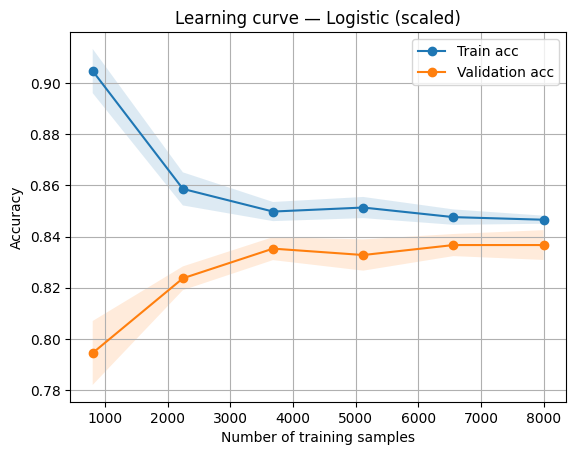


 Training a simple Logistic Regression baseline (Model 1)
Number of features: 258
Train samples:      10000
Test samples:       10000
Model training complete.

✅ Logistic Regression baseline trained for Model 1.
Predicted probabilities for test set: shape = (10000,)


In [6]:
# ---------------------------------------------
# 3.A Overfitting diagnostics (learning curve)
# ---------------------------------------------
feature_cols = [c for c in train_df.columns if c not in ("battle_id", "player_won")]
X = train_df[feature_cols].values
y = train_df["player_won"].values

print("📈 Running overfitting diagnostics (learning curve) for Model 1...")
lc_info = model1.diagnose_overfitting(
    X=X,
    y=y,
    cv_splits=5,
    max_iter=1000,
    plot=True,
    verbose=True,
)

# lc_info contains the learning curve summary if you want to inspect it.

# ---------------------------------------------
#  Train simple Logistic Regression baseline
# ---------------------------------------------
logreg_model, logreg_test_proba, logreg_features = model1.train_logreg_baseline(
    train_df=train_df,
    test_df=test_df,
    random_state=42,
    max_iter=3000,
    verbose=True,
)

print("\n✅ Logistic Regression baseline trained for Model 1.")
print(f"Predicted probabilities for test set: shape = {logreg_test_proba.shape}")


In [7]:
# === 4.A Modeling ===

print("\n🚀 Running feature selection + base models + stacking for Model 1...")

model1_stack_results = model1.run_feature_selection_and_stacking(
    train_df=train_df,
    test_df=test_df,
    corr_threshold=0.92,
    l1_coef_threshold=0.003,
    random_state=42,
    verbose=True,
)

# Convenient aliases for later steps (e.g. threshold tuning + submission)
stack_test_proba_model1  = model1_stack_results["stack_test_proba"]
stack_train_scores_model1 = model1_stack_results["stack_train_scores"]
y_train_model1           = model1_stack_results["y"]

print("\n✅ Model 1 stacking probabilities ready.")
print(f"Train scores shape : {stack_train_scores_model1.shape}")
print(f"Test  proba shape  : {stack_test_proba_model1.shape}")



🚀 Running feature selection + base models + stacking for Model 1...

 3.2–3.8 Feature selection + base models + stacking (Model 1)
Feature count before: 258
Removed constants   : 33
Removed by corr     : 41  (thr=0.92)
Feature count after : 184

Evaluating Logistic Regression with L1 regularization...
Validation Accuracy (L1): 0.8380
[L1 selection] kept 115 / 184 features (threshold=0.003)
[L1 selection] 5-fold CV accuracy: 0.8364 ± 0.0047

[3.5] KNN: K selection with CV...
KNN CV accuracies: {3: 0.5633, 5: 0.5747, 7: 0.577, 9: 0.5791, 11: 0.5844, 13: 0.5845, 15: 0.5836, 17: 0.5851, 21: 0.5912, 25: 0.5923, 31: 0.5952}
Best K = 31 (CV acc=0.5952)

[3.6] Random Forest shallow vs deep via CV...
RF CV accuracies: {'shallow': 0.8155, 'deep': 0.8206}
Best RF = deep (CV acc=0.8206)

[3.7] XGBoost with CV...
XGB CV accuracy: 0.8324

[3.8] Stacking ensemble (LogL1 + RF + KNN + XGB → Logistic meta)...
✅ Stacking (LogL1 + RF + KNN + XGB → Logistic meta) ready.

✅ Model 1 stacking probabilities r

In [8]:
# === 5.A Treshold tuning + creating submission file ===

print("\n🔧 Threshold tuning + submission for Model 1...")

stack_train_oof_model1   = model1_stack_results["stack_train_oof"]     # OOF meta-features
stack_test_proba_model1  = model1_stack_results["stack_test_proba"]    # P(y=1) on TEST
y_train_model1           = model1_stack_results["y"]                   # labels (Series)
battle_ids_test          = test_df["battle_id"].values

tuning_result_model1 = model1.tune_threshold_and_build_submission(
    stack_train_oof=stack_train_oof_model1,
    y=y_train_model1,
    test_scores=stack_test_proba_model1,
    battle_ids=battle_ids_test,
    th_min=0.30,
    th_max=0.70,
    th_step=0.005,
    n_splits=5,
    random_state=42,
    save_path="submission_model1.csv",  
    verbose=True,
)

best_thr_model1   = tuning_result_model1["best_thr"]
best_acc_model1   = tuning_result_model1["best_acc"]
submission_model1 = tuning_result_model1["submission"]
thr_df_model1     = tuning_result_model1["thresholds_df"]

print(f"\n✅ Model 1 submission saved as 'submission_model1.csv'")
print(f"Best threshold: {best_thr_model1:.3f} | OOF accuracy: {best_acc_model1:.4f}")

# (Opzionale) tabella soglie intorno al best
best_idx = thr_df_model1["oof_accuracy"].idxmax()
display(
    thr_df_model1.iloc[max(0, best_idx - 5): best_idx + 6].reset_index(drop=True)
)

# (Opzionale) preview della submission
display(submission_model1.head())
submission_model1 = submission_model1.copy()


🔧 Threshold tuning + submission for Model 1...

 3.9 Threshold tuning on OOF meta-features + submission
stack_train_oof shape : (10000, 4)
y length              : 10000
test_scores length    : 10000
battle_ids length     : 10000

Best threshold on OOF = 0.540 | OOF Accuracy = 0.8373
✅ Created tuned test labels using best threshold.

✅ Submission saved to submission_model1.csv

✅ Model 1 submission saved as 'submission_model1.csv'
Best threshold: 0.540 | OOF accuracy: 0.8373


,threshold,oof_accuracy
0,0.515,0.8367
1,0.520,0.8363
2,0.525,0.8362
3,0.530,0.8364
4,0.535,0.8370
5,0.540,0.8373
6,0.545,0.8369
7,0.550,0.8372
8,0.555,0.8367
9,0.560,0.8370


,battle_id,player_won
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


# SUBMISSION 2 - for *"fork-of-vit-notebook-fds.py"*
- **Feature engineering**:
    - A large, deterministic FE pipeline that extracts static team stats, timeline-based HP series, move-based features (power/accuracy/priority), type effectiveness, STAB, early/mid/late momentum, hazards/switches, damage proxies, and many composite engineered features (signed log transforms, top-5 “extra strong” features, stack-oriented meta-features).
    - Global training-time stats: per-Pokémon winrates, average HP stats, average damage computed from full train set and used as features.
    - Robust sanitization: fillna/finite clipping, signed-log transforms, and a final RobustScaler applied to numeric columns.
    - Some final manual interactions and engineered meta-features (10 safe features + top-5 extra features + XGB-inspired transforms).
- **Feature selection**:
    - Constant-feature removal, correlation pruning for LR (|ρ|>0.95), then per-model Top-K (LR/XGB/RF) computed via LR coefficient magnitudes, XGB feature_importances_, RF feature_importances_. Union of selected features used to create reduced train/test frames.
- **Modeling & stacking**:
    - Base learners: LogisticRegression (scaled), XGBoost (hist tree, early stopping, then sigmoid calibration), RandomForest (calibrated). Default seeds and sensible hyper-parameter choices are present (e.g., XGB: n_estimators=2000, lr=0.03, max_depth=6; RF with n_estimators=400, max_depth=8).
    - K-fold OOF stacking: FOLDS = 20 stratified folds. For each fold, base learners are trained, their calibrated val probabilities stored in oof_base; per-fold test probabilities are stored and averaged.
    - Meta-learner: LogisticRegression on the 3-column OOF probability matrix. There is also a small grid search over meta C and random_state to pick best meta config (replaces oof_meta_scores / meta_test_scores with best config).
- **Threshold tuning**:
    - Scan thresholds between 0.30 and 0.70 (401 values) on meta OOF probabilities. Metrics considered: accuracy, F1, MCC, ROC-AUC, logloss. Selected operating threshold prioritizes accuracy > F1 > MCC ties.

In [9]:
# === 1B. FEATURE ENGINEERING ===
import json
from importlib.machinery import SourceFileLoader

REPO_NAME = "FDS_COMP_2025"
model2_path = f"{REPO_NAME}/model-2.py"

# Carica il modulo del modello 2 (feature engineering avanzato)
model2 = SourceFileLoader("model2_module", model2_path).load_module()

# --- feature engineering modello 2 ---
# NB: run_feature_engineering_fork è la funzione che abbiamo definito nel file fork-of-vit-notebook-fds.py
train_df_m2, test_df_m2, train_df_raw_m2, test_df_raw_m2, scaler_m2 = model2.run_feature_engineering_fork(
    train_data=train_data,
    test_file_path=test_file_path,
)

print("[CHECK M2] train_df_m2 columns:", len(train_df_m2.columns))
print("[CHECK M2] test_df_m2  columns:", len(test_df_m2.columns))


Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Training features preview:
[FeatureEng] Added 10 engineered features. Bad values -> train: 0, test: 0

Preview (raw):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,atk_def_ratio,spd_gap,hp_ratio,survival_score,momentum_index,power_acc_gap,offensive_balance,defensive_efficiency,status_influence,speed_ratio
0,6,1,5,2,3190.0,535.0,88.611111,89.166667,5,3,...,0.0,0.0,0.0,0.0,0.0,-14.564148,0.0,0.0,0.0,0.0
1,6,1,6,2,3020.0,540.0,83.888889,90.000000,5,4,...,0.0,0.0,0.0,0.0,0.0,22.866543,0.0,0.0,0.0,0.0
2,6,1,8,2,3155.0,520.0,87.638889,86.666667,5,6,...,0.0,0.0,0.0,0.0,0.0,-17.966488,0.0,0.0,0.0,0.0
3,6,1,8,2,3285.0,520.0,91.250000,86.666667,5,6,...,0.0,0.0,0.0,0.0,0.0,-19.889786,0.0,0.0,0.0,0.0
4,6,1,6,2,3220.0,535.0,89.444444,89.166667,5,4,...,0.0,0.0,0.0,0.0,0.0,-11.130913,0.0,0.0,0.0,0.0



Scaling completed. Preview (scaled):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,atk_def_ratio,spd_gap,hp_ratio,survival_score,momentum_index,power_acc_gap,offensive_balance,defensive_efficiency,status_influence,speed_ratio
0,0.0,0.0,-1.0,0.0,0.157895,-0.25,0.157895,-0.25,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,-0.377566,0.0,0.0,0.0,0.0
1,0.0,0.0,-0.5,0.0,-1.631579,0.00,-1.631579,0.00,0.0,-0.5,...,0.0,0.0,0.0,0.0,0.0,0.636215,0.0,0.0,0.0,0.0
2,0.0,0.0,0.5,0.0,-0.210526,-1.00,-0.210526,-1.00,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,-0.469716,0.0,0.0,0.0,0.0
3,0.0,0.0,0.5,0.0,1.157895,-1.00,1.157895,-1.00,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,-0.521807,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.5,0.0,0.473684,-0.25,0.473684,-0.25,0.0,-0.5,...,0.0,0.0,0.0,0.0,0.0,-0.284580,0.0,0.0,0.0,0.0


[Advanced Top-5] Added 5 features to train_df: ['feat_lead_matchup_enh', 'feat_team_synergy', 'feat_early_momentum_refined', 'feat_kill_pressure', 'feat_switch_pressure']
[Advanced Top-5] Added 5 features to test_df: ['feat_lead_matchup_enh', 'feat_team_synergy', 'feat_early_momentum_refined', 'feat_kill_pressure', 'feat_switch_pressure']
[Cell 2] Added 5 extra stack features: ['clutch_win_index', 'dominant_win_index', 'status_efficiency', 'ko_efficiency', 'team_winrate_spread']

[Advanced Top-5] train_df shape: (10000, 258)
[Advanced Top-5] test_df  shape: (10000, 258)
[CHECK M2] train_df_m2 columns: 258
[CHECK M2] test_df_m2  columns: 258


In [10]:
# ============================================
# 2B. FEATURE SELECTION — 
# ============================================
# Execute feature selection
(
    train_reduced_m2,
    test_reduced_m2,
    selected_cols_lr_m2,
    selected_cols_xgb_m2,
    selected_cols_rf_m2,
    selected_cols_union_m2,
    imp_df_m2,
) = model2.run_feature_selection_fork(
    train_df=train_df_m2,   # ← output of Model2 FE
    test_df=test_df_m2,
    target_col="player_won",
    top_k_lr=90,
    top_k_xgb=187,
    top_k_rf=160,
    corr_threshold=0.95,
)

print("[M2] train_reduced_m2:", train_reduced_m2.shape)
print("[M2] test_reduced_m2 :", test_reduced_m2.shape)
print("[M2] total selected features:", len(selected_cols_union_m2))

[Init] Starting with 256 features.

[Pruning][A] Constant features removed: 45
[Pruning][A] After removal: 211 features

[Pruning][B] Correlation pruning for LR (|ρ| > 0.95) ...
[Pruning][B] LR correlation-pruned: 56

[FS][XGB] Training XGB for feature importance...
[FS][RF ] Training RandomForest...
[FS][LR ] Training LogisticRegression...
[M2] train_reduced_m2: (10000, 199)
[M2] test_reduced_m2 : (10000, 198)
[M2] total selected features: 197


In [11]:
# ============================================
# 3.B - Stacking + Meta-search 
# ============================================

# Run stacking + meta-search
oof_meta_scores_m2, meta_test_scores_m2, y_m2 = model2.run_stacking_and_meta_search(
    train_reduced=train_reduced_m2,
    test_reduced=test_reduced_m2,
    selected_cols_lr=selected_cols_lr_m2,
    selected_cols_xgb=selected_cols_xgb_m2,
    selected_cols_rf=selected_cols_rf_m2,
    target_col="player_won",
    folds=20,
    random_state=42,
)

print("\n[CHECK] Shapes:")
print("  oof_meta_scores_m2 :", oof_meta_scores_m2.shape)
print("  meta_test_scores_m2:", meta_test_scores_m2.shape)
print("  y_m2               :", y_m2.shape)


[Stack LR+XGB+RF→LR] Using 90 LR features, 187 XGB features, 160 RF features on 10000 training rows.

[Per-fold validation summary]
  [Fold  1] LR   acc=0.8240 | AUC=0.8933   ||  XGB  acc=0.8220 | AUC=0.8870 | best_iter=153   ||  RF   acc=0.8020  | AUC=0.8745
  [Fold  2] LR   acc=0.8260 | AUC=0.8929   ||  XGB  acc=0.8300 | AUC=0.8932 | best_iter=235   ||  RF   acc=0.8000  | AUC=0.8830
  [Fold  3] LR   acc=0.8300 | AUC=0.9002   ||  XGB  acc=0.8220 | AUC=0.8931 | best_iter=209   ||  RF   acc=0.8040  | AUC=0.8793
  [Fold  4] LR   acc=0.8360 | AUC=0.9086   ||  XGB  acc=0.8480 | AUC=0.9081 | best_iter=400   ||  RF   acc=0.8240  | AUC=0.9016
  [Fold  5] LR   acc=0.8340 | AUC=0.9011   ||  XGB  acc=0.8420 | AUC=0.9067 | best_iter=333   ||  RF   acc=0.8060  | AUC=0.8892
  [Fold  6] LR   acc=0.8600 | AUC=0.9230   ||  XGB  acc=0.8460 | AUC=0.9169 | best_iter=370   ||  RF   acc=0.8300  | AUC=0.8969
  [Fold  7] LR   acc=0.8400 | AUC=0.9158   ||  XGB  acc=0.8280 | AUC=0.9088 | best_iter=310   ||  RF

In [12]:
# ============================================
# 3.3 + 4 — Threshold tuning + submission (Model 2)
# ============================================
from importlib.machinery import SourceFileLoader
import pandas as pd
import os

# Load Model 2 module (only if not already loaded)
if "model2" not in globals():
    model2 = SourceFileLoader("model2_module", model2_path).load_module()

# Run advanced threshold tuning + build submission DataFrame
threshold_result_m2 = model2.run_threshold_tuning_and_submission(
    oof_meta_scores=oof_meta_scores_m2,
    meta_test_scores=meta_test_scores_m2,
    y=y_m2,
    test_df=test_df_m2,
    submission_filename="submission_model2.csv",  # logical name, we'll force path below
    thr_min=0.30,
    thr_max=0.70,
    thr_points=401,
)

# Unpack handy outputs
stacking_best_threshold_m2 = threshold_result_m2["best_threshold"]
stacking_submission_m2     = threshold_result_m2["submission"]
stack_pred_labels_tuned_m2 = threshold_result_m2["stack_pred_labels_tuned"]
thr_df_m2                  = threshold_result_m2["thr_df"]
oof_metrics_m2             = threshold_result_m2["oof_metrics"]

# --- Explicitly save to Kaggle working directory so it appears in "Output" ---
save_path_m2 = "/kaggle/working/submission_model2.csv"
stacking_submission_m2.to_csv(save_path_m2, index=False)

print(f"\n[CHECK] Best threshold (Model 2): {stacking_best_threshold_m2:.4f}")
print(f"[CHECK] Submission shape (Model 2): {stacking_submission_m2.shape}")
print(f"[CHECK] Saved submission to: {save_path_m2}")

# Optional: keep a copy in memory with a clear name and preview
submission_model2 = stacking_submission_m2.copy()
display(stacking_submission_m2.head())


[3.3] Threshold tuning on 10000 OOF samples.

[3.3] Best by Accuracy:
threshold    0.497000
accuracy     0.841200
f1           0.840914
mcc          0.682404
auc          0.909147
logloss      0.388175
Name: 197, dtype: float64

[3.3] Best by F1:
threshold    0.358000
accuracy     0.836600
f1           0.842733
mcc          0.675257
auc          0.909147
logloss      0.388175
Name: 58, dtype: float64

[3.3] Best by MCC:
threshold    0.497000
accuracy     0.841200
f1           0.840914
mcc          0.682404
auc          0.909147
logloss      0.388175
Name: 197, dtype: float64

[3.3] Selected operating threshold = 0.4970

[3.3] Final OOF metrics at selected threshold:
  Accuracy = 0.8412
  F1       = 0.8409
  MCC      = 0.6824
  AUC      = 0.9091

[3.3] Submission preview:


,battle_id,player_won
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1



[4] Submission file 'submission_model2.csv' created.
[4] Submission shape: (10000, 2)

[CHECK] Best threshold (Model 2): 0.4970
[CHECK] Submission shape (Model 2): (10000, 2)
[CHECK] Saved submission to: /kaggle/working/submission_model2.csv


,battle_id,player_won
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


# SUBMISSION 3 - for *"mrk-notebook-fds.py"*
- **Feature engineering**
    - High-level approach:
        - Extensive handcrafted features built from each battle's JSON record and its battle_timeline. Features include static team stats, timeline-derived HP/momentum signals, move statistics, type-effectiveness, hazards, switches, recoveries, and several domain heuristics.
    - Key helper functions and patterns:
        - Timeline and HP: get_timeline, _extract_hp_series, _mean_last_std_min, _slope, _auc_pct, _ko_count.
        - Move stats and windows: _move_stats_for_side, which derives mean base_power / accuracy / priority (both full and windowed).
        - Type & STAB: _type_multiplier, _avg_type_eff_p1_vs_p2lead, _name_to_types_map_p1, _stab_features.
        - Early-game and momentum: _early_momentum_features, _first_ko_flag, _priority_counts, _priority_feature_block.
        - Lead matchup / damage index: _simple_damage_index, _p1_vs_p2lead_matchup_index that computes simple damage proxies combining base_power, STAB, type effectiveness, and atk/def proxies.
        - Switch, hazard and recovery heuristics: _switch_count, _hazard_flags, _recovery_pressure, _momentum_shift.
        - Aggregation helpers: new_features, new_features_deb, new_features_mirko which produce many higher-level, human-interpretable features (e.g., final_hp_winner, team strength gap, predicted_win_prob, final_battle_score, final_win_probability).
        - Global statistics built from train set: build_pokemon_win_stats, build_pokemon_hp_stats, build_pokemon_avg_damage — used to create team-level win-rate / HP / avg-damage features.
        - Single-record assembly: _one_record_features collects static team metrics, timeline HP summaries, type/lead indices, move-derived metrics, and calls the new_features* blocks and damage features; create_simple_features applies _one_record_features to all records and returns a DataFrame.
    - Interaction & engineered features:
        - Post-processing creates additional interaction columns (_maybe_add_interactions) such as speed × priority, type-effectiveness × STAB, lead_matchup × early momentum, etc.
        - A separate “10 safe, high-signal features” block constructs robust aggregated features (e.g., atk_def_ratio, spd_gap, hp_ratio, survival_score, momentum_index, power_acc_gap, offensive_balance, defensive_efficiency, status_influence, speed_ratio). These are sanitized (clip, safe divide, float32) and validated for NaN/Inf.
    - Data sanitation:
        - Convert numeric columns to float32, replace +/-inf with NaN, clip percent-like fields (hp/auc) into sensible bounds, and detect near-constant columns (for informational purposes).
        - Utilities for safe division, pick-first from candidate columns, and normalization of accuracy features.
- **Feature selection**
    - Train-only pruning followed by a learned selector (Elastic Net logistic with CV). The pipeline purposefully avoids leaking test information and performs multiple pruning steps before the selector.
    - Pruning steps in order:
        - Constant removal: drop columns with ≤1 distinct observed value.
        - Correlation pruning: compute Pearson correlation on imputed train data; drop one side of pairs with |ρ| > CORR_THR (CORR_THR = 0.99).
        - Robust VIF pruning: iterative VIF computed on standardized, imputed train columns. Config: DROP_VIF True, VIF_THRESHOLD = 25.0, MAX_VIF_STEPS = 50. The VIF uses sklearn LinearRegression to compute R^2 per-column, dropping highest-VIF until below threshold or max steps.
    - Elastic Net selector:
        - Model: LogisticRegressionCV with penalty="elasticnet", solver="saga".
        - Post-fit selection: take absolute coefficients, then select a top-N by absolute weight. 
- **Modelling**
    - Overall architecture:
        - Base learners: Logistic Regression, XGBoost, Random Forest.
        - Stacking: true out-of-fold (OOF) stacking with per-fold training of base learners, calibration of probabilistic outputs on the validation fold, then a logistic meta-learner trained on base OOF probabilities.
        - Multi-seed runs: the notebook provides a multi-seed ensemble wrapper that repeats the stacking pipeline for multiple seed combinations and selects the best OOF AUC run.
    - Base learner details and hyperparameters:
        - Logistic Regression (base/layer-0): Pipeline: StandardScaler + LogisticRegression(solver="liblinear", penalty="l2", C=0.5, max_iter=3000). No calibration applied (probabilities from LR are used directly).
    - XGBoost:
        - XGBClassifier params: n_estimators=2000 (early stopping expected to cut it), learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, reg_alpha=0.0, objective="binary:logistic", eval_metric="logloss", tree_method="hist", random_state variable per run.
        - Trained with early stopping against the fold validation set; after fit a per-fold sigmoid calibration (CalibratedClassifierCV with cv="prefit") is applied on the validation fold.
    - Random Forest:
        - RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_leaf=10, max_features="sqrt", bootstrap=True, n_jobs=-1).
        - Per-fold sigmoid calibration (CalibratedClassifierCV with cv="prefit") on the fold validation.
    - Stacking details:
        - K-folds: FOLDS = 10 (StratifiedKFold shuffle=True). For each fold: train base learners on fold train, predict probs on fold val (store in oof_base) and on test (store per-fold test predictions).
        - After folds: aggregate test probs by averaging across folds to produce test_base_mean.
        - Meta-learner: LogisticRegression(solver="lbfgs", penalty="l2", C=1.0, max_iter=5000). The notebook builds a true OOF for the meta via a second StratifiedKFold over the base OOF features, fits meta per meta-fold, and averages meta predictions on test across meta folds.
        - Multi-seed ensemble: the notebook runs several seed combinations (explicit tuple list) repeating the entire stacking pipeline and records each run’s OOF AUC; the best run is selected (best_result) for threshold tuning/submission.
    - Calibration:
        - Both XGBoost and RandomForest receive per-fold sigmoid calibration using CalibratedClassifierCV(prefit) fitted on the validation fold to improve probability quality and prevent calibration leakage.
- **Threshold tuning**
    - Choose the final binary decision threshold for the stacked meta OOF probabilities to maximize a chosen metric (accuracy in this notebook).
    - Procedure implemented:
        - Baseline accuracy computed at threshold 0.50: oof_acc_default = accuracy_score(y, (oof_meta_scores >= 0.50).astype(int)).
        - Coarse search: thresholds ths_coarse = np.linspace(0.30, 0.70, 121) (step ≈ 0.0033). Compute accuracy across those thresholds, pick coarse best.
        - Fine search: define a narrow window around the coarse best (±0.05), then search ths_fine = np.arange(fine_lo, fine_hi + 1e-12, 0.001) (step 0.001). Pick the threshold with the highest OOF accuracy.
        - Store final values: STACK_FINAL_THRESHOLD, STACK_FINAL_OOF_ACC. Apply threshold to meta_test_scores to produce stack_pred_labels_tuned for submission.


In [13]:
# === 1.C – FEATURE ENGINEERING FOR MODEL 3 (MODULE CALL) ===
import json
from importlib.machinery import SourceFileLoader

# Path to your model-3.py inside the Kaggle working directory
model3_path = "FDS_COMP_2025/model-3.py"

# Load the module dynamically
model3 = SourceFileLoader("model3_module", model3_path).load_module()

# Run full feature engineering for Model 3
train_df_m3, test_df_m3, train_df_raw_m3, test_df_raw_m3 = model3.run_feature_engineering_mrk(
    train_data=train_data,        # list of dicts already loaded from train.jsonl
    test_file_path=test_file_path,  # path to test.jsonl
    alpha=1.0,                    # smoothing for Pokémon winrate stats
)

print("[CHECK][Model 3] train_df_m3 columns:", len(train_df_m3.columns))
print("[CHECK][Model 3] test_df_m3  columns:", len(test_df_m3.columns))

# Optionally, if you want to continue the pipeline using generic names:
train_df = train_df_m3.copy()
test_df  = test_df_m3.copy()



[Model 3] Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


[Model 3] Processing test data from JSONL...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


[Model 3] Training features preview:
[Sanity] Near-constant features (not dropping yet): 117
[FeatureEng] Added 10 engineered features. Bad values -> train: 0, test: 0

Preview (raw):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,damage_prediction,ix_p1avg_x_p1pow,ix_speed_x_prio5,ix_hpmean_x_fracadv,ix_early3_x_prio5,ix_stabdiff_x_firstko,ix_ter_x_stab_full,ix_ter5_x_early3,ix_leadmatch5_x_early3,ix_hazards_x_prio5
0,6,1,5,2,3190.0,535.0,88.611111,89.166667,5,3,...,1.0,5103.343621,0.0,-0.012237,-0.0,0.000000,0.768176,-0.234097,-18.532655,0.0
1,6,1,6,2,3020.0,540.0,83.888889,90.000000,5,4,...,1.0,7353.043478,-0.0,-0.030833,-0.0,0.000000,0.737240,-0.200000,-24.000089,0.0
2,6,1,8,2,3155.0,520.0,87.638889,86.666667,5,6,...,1.0,3086.836420,0.0,0.021089,0.0,0.000000,0.422497,0.170000,19.671460,0.0
3,6,1,8,2,3285.0,520.0,91.250000,86.666667,5,6,...,1.0,6169.293478,0.0,-0.025778,-0.0,-0.391304,0.391304,-0.806667,-111.872196,0.0
4,6,1,6,2,3220.0,535.0,89.444444,89.166667,5,4,...,1.0,3127.115385,0.0,0.013289,-0.0,0.000000,0.248521,-0.186000,-0.092190,0.0



Prepared (unscaled, clean types):


,p1_team_size,p2_team_size,p1_unique_types,p2_unique_types,p1_team_stat_sum,p2_team_stat_sum,p1_team_stat_avg,p2_team_stat_avg,diff_team_size,diff_unique_types,...,atk_def_ratio,spd_gap,hp_ratio,survival_score,momentum_index,power_acc_gap,offensive_balance,defensive_efficiency,status_influence,speed_ratio
0,6.0,1.0,5.0,2.0,3190.0,535.0,88.611115,89.166664,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,-14.564148,0.0,0.0,0.0,0.0
1,6.0,1.0,6.0,2.0,3020.0,540.0,83.888885,90.000000,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,22.866543,0.0,0.0,0.0,0.0
2,6.0,1.0,8.0,2.0,3155.0,520.0,87.638885,86.666664,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,-17.966488,0.0,0.0,0.0,0.0
3,6.0,1.0,8.0,2.0,3285.0,520.0,91.250000,86.666664,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,-19.889786,0.0,0.0,0.0,0.0
4,6.0,1.0,6.0,2.0,3220.0,535.0,89.444443,89.166664,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,-11.130913,0.0,0.0,0.0,0.0


[CHECK][Model 3] train_df_m3 columns: 217
[CHECK][Model 3] test_df_m3  columns: 217


,train_size,train_acc_mean,train_acc_std,val_acc_mean,val_acc_std,gap_train_minus_val
0,800,0.882500,0.009747,0.8021,0.007378,0.080400
1,2240,0.851607,0.004903,0.8293,0.003234,0.022307
2,3679,0.847567,0.003624,0.8347,0.006853,0.012867
3,5120,0.847734,0.002346,0.8361,0.008639,0.011634
4,6560,0.845610,0.003039,0.8359,0.005463,0.009710
5,8000,0.843825,0.002026,0.8388,0.005662,0.005025



[Overfitting] Largest train size = 8000
  • Train acc (mean): 0.8438
  • Val   acc (mean): 0.8388
  • Gap (train - val): 0.0050

[Overfitting] Potential overfitting: NO


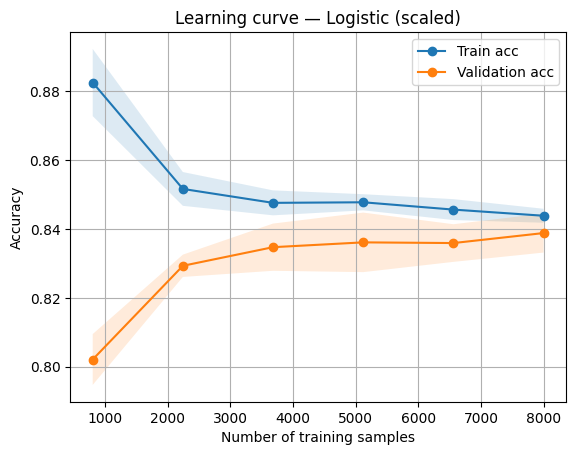

[Model 3] Overfitting flag: False


In [14]:
# === 2.C Overfitting diagnostics ===
overfit_results_m3 = model3.diagnose_overfitting_lr(
    train_df=train_df_m3,
    target_col="player_won",
    id_cols=["battle_id"],
    cv_splits=5,
    max_iter=1000,
    plot=True,
)

print("[Model 3] Overfitting flag:", overfit_results_m3["overfitting_flag"])


In [15]:
# === 3.1 Feature selection (Elastic Net + Top-N) ===
train_reduced_m3, test_reduced_m3, selected_cols_m3 = model3.run_feature_selection_mrk(
    train_df=train_df_m3,
    test_df=test_df_m3,
    target_col="player_won",
    id_cols=["battle_id"],
    random_state=42,
    drop_vif=True,
    vif_threshold=25.0,
    max_vif_steps=50,
    corr_threshold=0.99,
    cv_splits=5,
    target_n_features=60,
)

print("[Model 3] Reduced train shape:", train_reduced_m3.shape)
print("[Model 3] Reduced test  shape:", test_reduced_m3.shape)


[FS-M3] Original feature count (numeric, pre-pruning): 215
[FS-M3][A] Constant features removed: 43
  -> Constant list (first 50): ['p1_team_size', 'p2_team_size', 'p2_unique_types', 'diff_team_size', 'tl_turns_used', 'tl_hp_diff_min', 'tl_p1_status_count', 'tl_p2_status_count', 'tl_status_count', 'hazard_switch_pressure_diff', 'hazard_p1_flag', 'hazard_p2_flag', 'hazard_flag_diff', 'early_status_advantage_3', 'mv_p1_priority_count', 'mv_p2_priority_count', 'mv_priority_count_diff', 'mv_p1_priority_count_5', 'mv_p2_priority_count_5', 'mv_priority_count_diff_5', 'stronger_team', 'battle_length', 'long_battle', 'p1_hp_stability', 'p2_hp_stability', 'team_has_type_variety', 'p1_hp_over_50_ratio', 'p2_hp_over_50_ratio', 'is_player1_healthier', 'comeback_difficulty', 'damage_prediction', 'ix_speed_x_prio5', 'ix_early3_x_prio5', 'ix_hazards_x_prio5', 'atk_def_ratio', 'spd_gap', 'hp_ratio', 'survival_score', 'momentum_index', 'offensive_balance', 'defensive_efficiency', 'status_influence', 's

In [16]:
# === 3.C Stacking (LR + XGB + RF -> LR meta) ===

stacking_results_m3 = model3.run_stacking_mrk(
    train_reduced=train_reduced_m3,
    test_reduced=test_reduced_m3,
    selected_cols=selected_cols_m3,
    seeds=[(50, 55, 160)],  
    folds=15,
    meta_random_state=42,
)

# Variables for Cell 3.3 (threshold tuning)
y_m3 = stacking_results_m3["y"]
oof_meta_scores_m3 = stacking_results_m3["oof_meta_scores"]
meta_test_scores_m3 = stacking_results_m3["meta_test_scores"]

print("\n[Model 3] Best seed combo:", stacking_results_m3["best_seed"])
print("[Model 3] Best OOF AUC:", stacking_results_m3["best_auc"])
print("Ready for 3.3 threshold tuning (y_m3, oof_meta_scores_m3, meta_test_scores_m3)")


[Stack LR+XGB+RF→LR] Using 60 selected features on 10000 training rows.

Running stacking iteration 1
LR_seed=50, XGB_seed=55, RF_seed=160

[Per-fold validation summary]
  [Fold 1] LR  acc=0.8366 | AUC=0.9059  ||  XGB acc=0.8366 | AUC=0.9009 | best_iter=None  ||  RF  acc=0.8111 | AUC=0.8974
  [Fold 2] LR  acc=0.8321 | AUC=0.8969  ||  XGB acc=0.8171 | AUC=0.8900 | best_iter=None  ||  RF  acc=0.8066 | AUC=0.8772
  [Fold 3] LR  acc=0.8396 | AUC=0.9087  ||  XGB acc=0.8396 | AUC=0.9046 | best_iter=None  ||  RF  acc=0.8276 | AUC=0.9018
  [Fold 4] LR  acc=0.8396 | AUC=0.9084  ||  XGB acc=0.8321 | AUC=0.9095 | best_iter=None  ||  RF  acc=0.8216 | AUC=0.8941
  [Fold 5] LR  acc=0.8561 | AUC=0.9296  ||  XGB acc=0.8621 | AUC=0.9263 | best_iter=None  ||  RF  acc=0.8396 | AUC=0.9164
  [Fold 6] LR  acc=0.8546 | AUC=0.9172  ||  XGB acc=0.8441 | AUC=0.9121 | best_iter=None  ||  RF  acc=0.8426 | AUC=0.9096
  [Fold 7] LR  acc=0.8276 | AUC=0.8882  ||  XGB acc=0.8111 | AUC=0.8871 | best_iter=None  ||  RF  

In [17]:
# === 3.3 Threshold tuning for StackingClassifier (Model 3, notebook) ===
# Uses: y_m3, oof_meta_scores_m3, meta_test_scores_m3
# Requires: model3.tune_stacking_threshold_mrk

import numpy as np
from sklearn.metrics import accuracy_score

# --- Safety checks ---
required_vars_m3 = ["y_m3", "oof_meta_scores_m3", "meta_test_scores_m3"]
missing_m3 = [name for name in required_vars_m3 if name not in globals()]

if missing_m3:
    raise RuntimeError(
        f"Missing required objects for Model 3 threshold tuning: {missing_m3}. "
        f"Run the Model 3 training / OOF scoring cell first."
    )

# Ensure the function exists inside model3 module
if not hasattr(model3, "tune_stacking_threshold_mrk"):
    raise RuntimeError(
        "Function 'tune_stacking_threshold_mrk' is not defined inside model3. "
        "Verify that your GitHub model-3.py contains it."
    )

# --- Run threshold tuning ---
res_m3 = model3.tune_stacking_threshold_mrk(
    y=y_m3,
    oof_meta_scores=oof_meta_scores_m3,
    meta_test_scores=meta_test_scores_m3,
    verbose=True,
)

# --- Export results to global vars expected by Cell 4 ---
STACK_FINAL_THRESHOLD = float(res_m3["final_threshold"])
STACK_FINAL_OOF_ACC = float(res_m3["final_oof_acc"])
stack_pred_labels_tuned = res_m3["test_labels"].astype(int)

print("\n[Model 3 - Stacking] Threshold tuning complete.")
print(f"  Final tuned threshold: {STACK_FINAL_THRESHOLD:.6f}")
print(f"  Final OOF accuracy:    {STACK_FINAL_OOF_ACC:.6f}")
print("  Sample of tuned test labels:", stack_pred_labels_tuned[:10])


[Stacking][OOF] Accuracy @ 0.50 = 0.8407
[Stacking][Search] Coarse best: thr=0.477 | OOF acc=0.8410
[Stacking][Best] Final OOF threshold = 0.477 | OOF Accuracy = 0.8410

[Model 3 - Stacking] Threshold tuning complete.
  Final tuned threshold: 0.476667
  Final OOF accuracy:    0.841000
  Sample of tuned test labels: [1 1 1 0 1 1 1 0 1 1]


In [18]:
# === 4. Submission (StackingClassifier tuned threshold ONLY, Model 3) ===
import pandas as pd
import os

# --- Safety checks ---
if "stack_pred_labels_tuned" not in globals():
    raise RuntimeError(
        "Missing 'stack_pred_labels_tuned'. "
        "Run the Model 3 threshold tuning cell (3.3) first."
    )

if "test_df" not in globals():
    raise RuntimeError(
        "Missing 'test_df'. Make sure the feature engineering cell ran correctly."
    )

if "battle_id" not in test_df.columns:
    raise RuntimeError(
        "Column 'battle_id' not found in test_df. "
        "Check that feature engineering preserved this column."
    )

if len(stack_pred_labels_tuned) != len(test_df):
    raise RuntimeError(
        f"Length mismatch: stack_pred_labels_tuned ({len(stack_pred_labels_tuned)}) "
        f"vs test_df ({len(test_df)})."
    )

# --- Build submission DataFrame ---
submission = pd.DataFrame({
    "battle_id": test_df["battle_id"].values,
    "player_won": stack_pred_labels_tuned.astype(int)
})

# --- Save to Kaggle working directory ---
save_path = "/kaggle/working/submission_model3.csv"
submission.to_csv(save_path, index=False)

# Optional: keep a copy in memory with a clear name
submission_model3 = submission.copy()

# --- Info / preview ---
note = (
    f"StackingClassifier (LR + XGB + RF → LR meta), "
    f"tuned threshold = {float(STACK_FINAL_THRESHOLD):.3f}"
    if "STACK_FINAL_THRESHOLD" in globals()
    else "StackingClassifier (LR + XGB + RF → LR meta), tuned threshold (value not found)."
)

print(f"Submission for Model 3 saved to: {save_path}")
print(f"Note: {note}")
print("\nHead of submission:")
display(submission.head())



Submission for Model 3 saved to: /kaggle/working/submission_model3.csv
Note: StackingClassifier (LR + XGB + RF → LR meta), tuned threshold = 0.477

Head of submission:


,battle_id,player_won
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
